# A very gentle introduction to Feature Effect methods

This tutorial is a very gentle introduction to [feature effect methods](https://christophm.github.io/interpretable-ml-book/global-methods.html) and the `Effector` package.
We will explore the different feature effect methods offered by `Effector` and use them to explain a linear model.

Why a linear model? The feature effect of a linear model is trivial to compute, so we can easily understand what an ideal _feature effect_ should look like 
and then compare it with the output of the various feature effect methods within the `Effector` package.

If you only want to see how to use `Effector` you can skip the next sections and go directly to the table of the [Conclusion](#conclusion) section.


In [1]:
import numpy as np
import effector

---
## The dataset

We will generate $N=1000$ examples with $D=3$ features each:

<center>

| Feature | Description | Distribution |
| --- | --- | --- |
| $x_1$ | Uniformly distributed between $0$ and $1$ | $x_1 \sim \mathcal{U}(0,1)$ |
| $x_2$ | Normally distributed around $x_1$ with a small std of $0.01$ | $x_2 \sim \mathcal{N}(x_1, 0.01)$ |
| $x_3$ | Normally distributed with mean $0$ and standard deviation of $1$ | $x_3 \sim \mathcal{N}(0, 1)$ |

</center>

In [2]:
def generate_dataset(N, x1_min, x1_max, x2_sigma, x3_sigma):
    x1 = np.concatenate((np.array([x1_min]),
                         np.random.uniform(x1_min, x1_max, size=int(N - 2)),
                         np.array([x1_max])))
    x2 = np.random.normal(loc=x1, scale=x2_sigma)
    x3 = np.random.normal(loc=np.zeros_like(x1), scale=x3_sigma)
    return np.stack((x1, x2, x3), axis=-1)

# generate the dataset
np.random.seed(21)
N = 1000
x1_min = 0
x1_max = 1
x2_sigma = .01
x3_sigma = 1.
X = generate_dataset(N, x1_min, x1_max, x2_sigma, x3_sigma)

---
## The model

We will use the following linear model, $y = 7x_1 - 3x_2 + 4x_3$. As mentioned above, it is trivial to compute the effect of each feature; the effect of $x_i$ is simply $\alpha_i x_i$. Furthermore, since there are no interactions between the features, the effect of each feature is independent of the other features, so the heterogeneity is zero.

<center>

| Feature | Average Effect | Heterogeneity |
| --- | --- | --- |
| $x_1$ | $7x_1$ | 0 |
| $x_2$ | $-3x_2$ | 0 |
| $x_3$ | $4x_3$ | 0 |

</center>

In [3]:
def predict(x):
    y = 7*x[:, 0] - 3*x[:, 1] + 4*x[:, 2]
    return y

def predict_grad(x):
    df_dx1 = 7 * np.ones([x.shape[0]])
    df_dx2 = -3 * np.ones([x.shape[0]])
    df_dx3 = 4 * np.ones([x.shape[0]])
    return np.stack([df_dx1, df_dx2, df_dx3], axis=-1)

---
## Feature Effect methods

Feature effect methods explain the black-box model by estimating the effect of each feature on the model's prediction, i.e., they output a 1-1 mapping between the feature of interest $x_s$ and the ouput of the model $y$. `Effector` covers the following feature effect methods:

<center>

| Method                                  | Description                        | API in `Effector`                                                            | Paper                                                             |
|-----------------------------------------|------------------------------------|------------------------------------------------------------------------------|-------------------------------------------------------------------|
| [PDP](#partial-dependence-plot-pdp)     | Partial Dependence Plot            | [PDP]((./../../reference/#effector.pdp.DerivativePDP))                       | [Friedman, 2001](https://statweb.stanford.edu/~jhf/ftp/trebst.pdf) |
| [d-PDP](#derivative-pdp-d-pdp)          | Derivative PDP                     | [DerivativePDP](./../../reference/#effector.pdp.DerivativePDP)               | [Goldstein et. al, 2013](https://arxiv.org/pdf/1309.6392.pdf)     |
| [ICE](ICE(#ice-plots))                  | Individual Conditional Expectation | [PDPwithICE](./../../reference/#effector.pdp.PDPwithICE)                     | [Goldstein et. al, 2013](https://arxiv.org/pdf/1309.6392)         |
| [d-ICE](#derivative-pdp-d-pdp)          | Derivative ICE                     | [DerivativePDPwithICE](./../../reference/#effector.pdp.DerivativePDPwithICE) | [Goldstein et. al, 2013](https://arxiv.org/pdf/1309.6392.pdf)     |
| [ALE](#accumulated-local-effects-ale)   | Accumulated Local Effect           | [ALE](./../../reference/#effector.ale.ALE)                                   | [Apley et. al, 2016](https://arxiv.org/pdf/1612.08468)            |
| [RHALE](#accumulated-local-effects-ale) | Robust and Heterogeneity-aware ALE | [RHALE](./../../reference/#effector.ale.RHALE)                               | [Gkolemis et al, 2023](https://arxiv.org/abs/2309.11193)          | 

</center>

### Notation

Let' s estimate some notation for the rest of the tutorial:

<center>

| Symbol                                                     | Description                                             |
|------------------------------------------------------------|---------------------------------------------------------|
| $f(\mathbf{x})$                                            | The black box model                                     |
| $x_s$                                                      | The feature of interest                                 |
| $x_c$                                                      | The remaining features, i.e., $\mathbf{x} = (x_s, x_c)$ |
| $\mathbf{x} = (x_s, x_c) = (x_1, x_2, ..., x_s, ..., x_D)$ | The input features                                      |
| $\mathbf{x}^{(i)} = (x_s^{(i)}, x_c^{(i)})$                | The $i$-th instance of the dataset                      |

</center>

---
## Partial Dependence Plot (PDP)

The PDP is defined as **_the average of the model's prediction over the entire dataset, while varying the feature of interest._**
PDP is defined as 

$$ \text{PDP}(x_s) = \mathbb{E}_{x_c}[f(x_s, x_c)] $$ 

and is approximated by 

$$ \hat{\text{PDP}}(x_s) = \frac{1}{N} \sum_{j=1}^N f(x_s, x^{(i)}_c) $$

Let's check it out the PDP effect using `effector`.

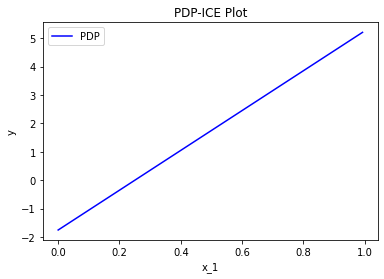

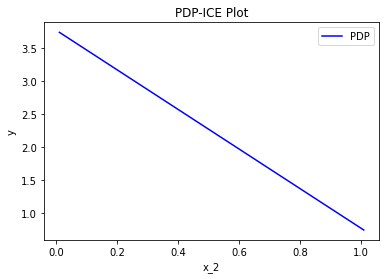

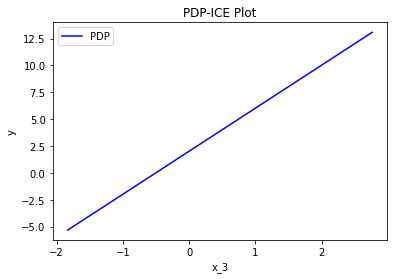

In [4]:
fig, ax = effector.PDP(data=X, model=predict).plot(feature=0)
fig, ax = effector.PDP(data=X, model=predict).plot(feature=1)
fig, ax = effector.PDP(data=X, model=predict).plot(feature=2)

### Feature effect interpretation

The effect estimated by PDP matches with the ground truth in all cases; it is a line with gradient $7$ for $x_1$, $-3$ for $x_2$ and $4$ for $x_3$.
However, it can be confusing the _centering_ of the PDP; In fact, in linear models the PDP plot extracts an $\text{PDP}(x_s) = a_sx_s + c$ where $a_s$ is the gradient of the line and $c$ is an intercept. In our case, the line is $7x_1 - 1.5$ so the intercept is $c \approx - 1.5$. Why this happens? 

$$PDP(x_s) = \mathbb{E}_{x_c}[f(x_s, x_c)] = a_sx_s + \sum_{j \neq s} a_j \mathbb{E}_{x_j}[x_j] = a_sx_s - 3 * 0.5 + 4 * 0 = a_sx_s - 1.5$$
 
`Effector` offers three alternative ways to center the PDP plot (and any feature effect plot) using the `centering` parameter. 
The first one is the one examined above, i.e. using `centering=False` which is the default:

| `centering`               | Description                            | Formula                                                                 |
|---------------------------|----------------------------------------|-------------------------------------------------------------------------|
| `False`                   | Don't enforce any additional centering | -                                                                       |
| `True` or `zero-integral` | Center around the $y$ axis             | $c = \mathbb{E}_{x_s \sim \mathcal{U(x_{s,min},x_{s, max})}}[PDP(x_s)]$ |
| `zero-start`              | Center around $y=0$                    | $c = 0$                                                                 |

Let's see how this works for $x_1$.

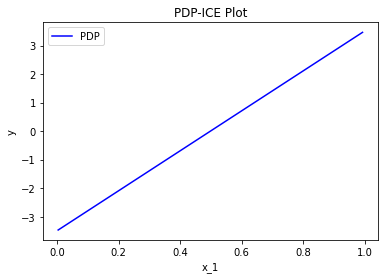

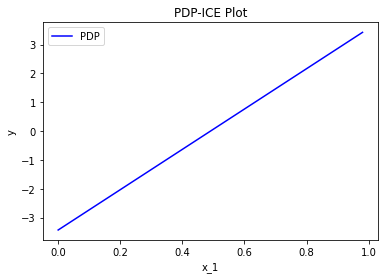

In [5]:
fig, ax = effector.PDP(data=X, model=predict).plot(feature=0, centering=True)
fig, ax = effector.PDP(data=X, model=predict).plot(feature=0, centering="zero_start")

### Heterogeneity or Uncertainty

Feature effect methods output a 1-1 plot that visualizes the **average** effect of a specific feature on the output.
The aggregation is done by averaging the instance-level effects. 
It is important for the end-user to know to what extent the underlying local (instance-level) effects deviate from the average effect.  
In PDP plots there are two ways to check that, either using the ICE plots or plotting the standard deviation of the instance level effects as $\pm$ interval around the PDP plot. 

#### ICE plots

ICE plots are defined as:

$$\text{ICE}^{(i)}(x_s, x^{(i)}_c) = f(x_s, x^{(i)}_c)$$

and they are plotted on-top of the PDP plot. Practically, the ICE plot shows how each instance $i$ performs if we vary the feature of interest $x_s$.
Plotting many ICE plots on top of the PDP plot, we can visually observe the heterogeneity of the instance-level effects.
For example in the plot below, we can see that there so no heterogeneity in the instance-level effects, i.e., all instance-level effects are lines with gradient 7.
However, be careful that this is more obvious using the argument `centering=True`.
If we omit centering, the instance-level effects may create the illusion of heterogeneity, although if with a closer look we can see that all ICE plots are lines with gradient 7.

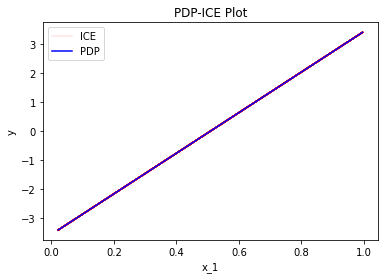

In [6]:
fig, ax = effector.PDP(data=X, model=predict).plot(feature=0, centering=True, confidence_interval="ice")

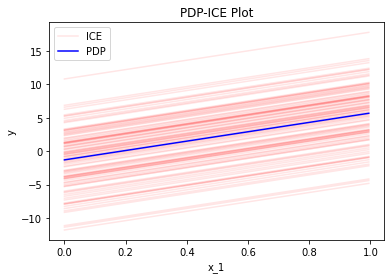

In [8]:
fig, ax = effector.PDP(data=X, model=predict).plot(feature=0, centering=False, confidence_interval="ice")

#### STD of the residuals

A second way to check for heterogeneity is by plotting the standard deviation of the instance-level effects as $\pm$ interval around the PDP plot.
This is done can be done by setting `confidence_interbal="std"` in the `plot` method.
However, as you can see below, it can be tricky. If the $\sigma$ of the instance-level effects is computed without centering the PDP and the ICE plots, it can erroneously indicate heterogeneity. The same issue was encountered above, at the uncentered version of the ICE plots. However, since ICE plots show the **type** of the heterogeneity, we could easily spot that the heterogeneity was only in the intercept and not in the gradient of the instance-level effects. Unfortunately, this is not the case with the standard deviation of the residuals, which in this case lead to a misleading interpretation. 

Therefore, we recommend to **always** use the centered version of the ICE, when measuring the heterogeneity with ICE plots.


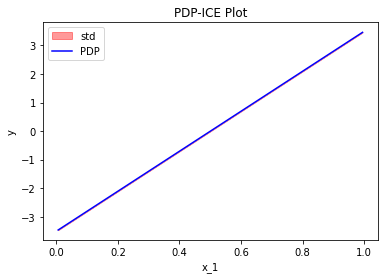

In [11]:
fig, ax = effector.PDP(data=X, model=predict).plot(feature=0, centering=True, confidence_interval="std")

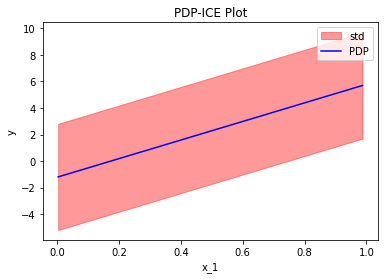

In [12]:
fig, ax = effector.PDP(data=X, model=predict).plot(feature=0, centering=False, confidence_interval="std")


### Derivative-PDP (d-PDP)

A similar analysis can be done using the derivative of the model; the name of this approach is Derivative-PDP (d-PDP) and the equivalent of the ICE plots are the Derivative-ICE (d-ICE) plots. The d-PDP and d-ICE are defined as:

$$ \text{d-PDP}(x_s) = \mathbb{E}_{x_c}[\frac{\partial f}{\partial x_s} (x_s, x_c)] \approx \frac{1}{N} \sum_{j=1}^N \frac{\partial f}{\partial x_s} (x_s, x_c^{(i)}) $$

and 

$$ \text{d-ICE}^{(i)}(x_s) = \frac{\partial f}{\partial x_s} (x_s, x^{(i)}_c) $$

We have to mention that:
 
* d-PDP needs the model's gradient, which is not always available.
* Under normal circumstances, the d-PDP should not be centered because the absolute value of the derivative has a natural meaning for the interpretation.
* The interpretation is given in the gradient-space, so it should be treated differently. In d-PDP the plots show how much the model's prediction *changes* given a change in the feature of interest. This is different from PDP, where the plots says how much the specific feature *contributes* to the prediction. 
* d-PDP is the gradient of the PDP, i.e., $\text{d-PDP}(x) = \frac{\partial \text{PDP}}{\partial x_s} (x)$
* d-ICE is the gradient of the ICE, i.e., $\text{d-ICE}^{(i)}(x) = \frac{\partial \text{ICE}^{(i)}}{\partial x_s} (x)$

As we can see below, the centering problem with the standard deviation of the the ICE plots is not present in the d-ICE plots. 
Therefore, both heterogeneity measures (d-ICE and $\sigma$ of the residuals) correctly indicate the heterogeneity is zero.

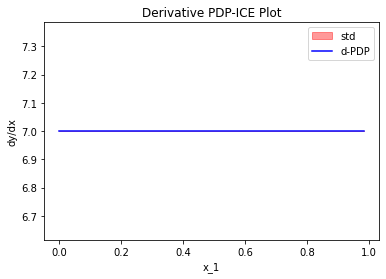

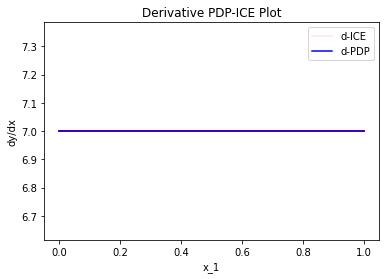

In [15]:
fig, ax = effector.DerivativePDP(data=X, model=predict, model_jac=predict_grad).plot(feature=0, confidence_interval=True)
fig, ax = effector.DerivativePDP(data=X, model=predict, model_jac=predict_grad).plot(feature=0, confidence_interval="ice")

## Accumulated Local Effects (ALE)

The next major category of feature effect techniques is [Accumulated Local Effects (ALE)](https://christophm.github.io/interpretable-ml-book/ale.html). Before we go into the specifics, let's apply the ALE plot to our example.

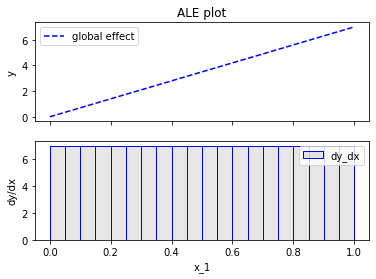

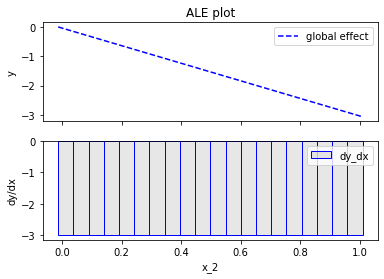

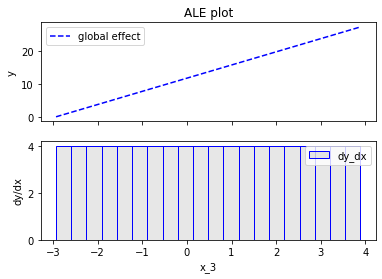

In [16]:
fig, ax1, ax2 = effector.ALE(data=X, model=predict).plot(feature=0)
fig, ax1, ax2 = effector.ALE(data=X, model=predict).plot(feature=1)
fig, ax1, ax2 = effector.ALE(data=X, model=predict).plot(feature=2)

### Fearure effect interpretation

In each of the figures above, there are two subfigures; the upper subfigure is the average feature effect (the typical ALE plot) and the lower subfigure is the derivative of the effect.
The upper subfigure shows how much the feature of interest _contributes_ to the prediction (like PDP) while the bottom subplot shows how much a change in the feature of interest _changes_ the prediction (like d-PDP). 
For example, for $x_1$ the upper subplot shows a linear effect and the lower subplot confirms that the gradient is constantly $7$.
`Effector` offers two alternatives for centering the ALE plot.

<center>

| `centering`               | Description                            | Formula                                                               |
|---------------------------|----------------------------------------|-----------------------------------------------------------------------|
| `False` or `zero-start`   | Don't enforce any additional centering | c=0                                                                   |
| `True` or `zero-integral` | Center around the $y$ axis             | c=$\mathbb{E}_{x_s \sim \mathcal{U(x_{s,min},x_{s, max})}}[ALE(x_s)]$ |

</center>
Let's see how centering works for $x_1$:

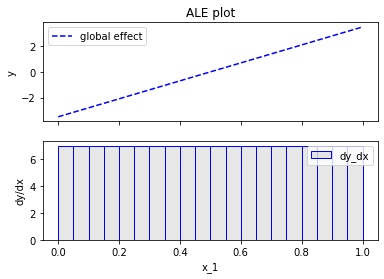

In [17]:
fig, ax1, ax2 = effector.ALE(data=X, model=predict).plot(feature=0, centering=True)

### Heterogeneity or Uncertainty

In ALE plots, the only way to check the heterogeneity of the instance-level effects is by plotting the standard deviation of the instance-level effects as $\pm$ interval around the ALE plot. In `Effector` this can be done by setting `confidence_interbal="std"`. The plot below informs shows that the heterogeneity is zero, which is correct. However, as we will see below [(RHALE section)](#robust-and-heterogeneity-aware-ale-rhale), ALE's fixed size bin-splitting is not the best way to estimate the heterogeneity. In contrast, the automatic bin-splitting introduced by [RHALE](https://arxiv.org/abs/2309.11193) provides a better estimation of the heterogeneity.

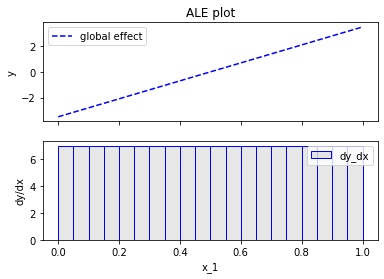

In [18]:
fig, ax1, ax2 = effector.ALE(data=X, model=predict).plot(feature=0, centering=True, confidence_interval="std")

### Bin-Splitting

As you may have noticed at the bottom plots of the figures above, $x_1$ axis has been split in $K=20$ bins (intervals) of equal size. The derivative-effect is provided per bin (bin-effect), which in our example is $7$ for all bins. 

In fact, bin-splitting is apparent also at the top plot; the top plot is not a line, but a piecewise linear function, where each _piece_ is a line in the are covered by each bin and gradient equal to the bin-effect. However, since the bin-effect is the same for all bins, the top plot looks like a line.

To explain the need for bin-splitting we have to go back to the definition of ALE. ALE is defined as: 

$$\text{ALE}(x_s) = \int_{z=0}^{x_s} \mathbb{E}_{x_c|x_s=z}\left [ \frac{\partial f}{\partial x_s} (z, x_c) \right ] \partial z$$

Apley et. al proposed approximating the above integral by:

$$\hat{\text{ALE}}(x_s) = \sum_{k=1}^{k_{x_s}} \frac{1}{| \mathcal{S}_k |} \sum_{i: x^{(i)} \in \mathcal{S}_k} \left [ f(z_k, x_c) - f(z_{k-1}, x_c) \right ]$$

where $k_{x_s}$ the index of the bin such that $z_{k_{x−1}} ≤ x_s < z_{k_x}$, $\mathcal{S}_k$ is the set of the instances lying at the $k$-th bin, i.e., $\mathcal{S}_k = \{ x^{(i)} : z_{k−1} \neq x^{(i)}_s < z_k \}$ and $\Delta x = \frac{x_{s, max} - x_{s, min}}{K}$.

$\hat{\text{ALE}}(x_s)$ uses a Riemannian sum to approximate the integral of $\text{ALE}(x_s)$. The axis of the $s$-th feature is split in $K$ bins (intervals) of equal size. In each bin, the average effect of the feature of interest is estimated using the instances that fall in the bin. The average effect in each bin is called bin-effect. The default in `Effector` is to use $K=20$ bins but the user can change it using:

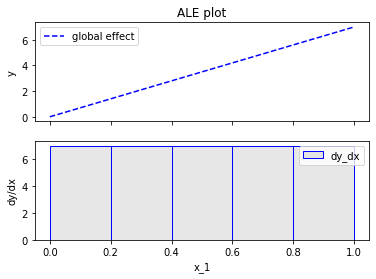

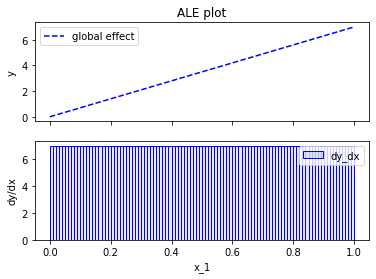

In [19]:
ale = effector.ALE(data=X, model=predict)

# using 5 bins
bm = effector.binning_methods.Fixed(nof_bins=5, min_points_per_bin=0, cat_limit=10)
ale.fit(features=0, binning_method=bm)
fig, ax1, ax2 = ale.plot(feature=0)

# using 100 bins
bm = effector.binning_methods.Fixed(nof_bins=100, min_points_per_bin=0, cat_limit=10)
ale.fit(features=0, binning_method=bm)
fig, ax1, ax2 = ale.plot(feature=0)

## Robust and Heterogeneity-aware ALE (RHALE)

Robust and Heterogeneity-aware ALE (RHALE) is a variant of ALE, proposed by [Gkolemis et. al](https://arxiv.org/abs/2309.11193). In their paper, they showed that RHALE has specific advantages over ALE: (a) it ensures on-distribution sampling (b) an unbiased estimation of the heterogeneity and (c) an optimal trade-off between bias and variance. These are achieved using an automated variable-size binning splitting approach. Let's see how it works in practice.

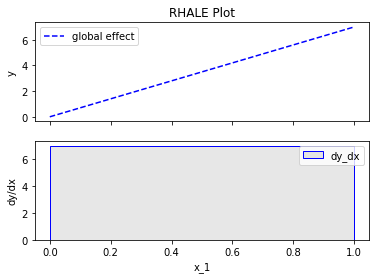

In [25]:
fig, ax1, ax2 = effector.RHALE(data=X, model=predict, model_jac=predict_grad).plot(feature=0, centering=False, show_avg_output=False)

### Fearure effect interpretation

The interpretation is exactly the same as with the typical ALE; The top subplot is the average feature effect and the bottom subfigure is the derivative of the effect. 
The crucial difference, is that the automatic bin-splitting approach _optimally_ creates a single bin that covers the whole area between $x=0$ and $x=1$. As we saw above, the gradient of the feature effect is constant and equal to $7$ for all $x_1$ values. Therefore, merging all bins into one, reduces the variance of the estimation; the estimation is based on more instances, so the variance is lower. 

In our example, this advantage is not that evident. Since there are no interaction terms (linear model) the effect of all instances is always the same; so the variance of the estimation is zero. However in more complex models, the variance of the estimation is not zero and the automatic bin-splitting approach reduces the variance of the estimation (check tutorial [ALE](./ale.ipynb) for more details).

As with the ALE, there are two alternatives for centering the ALE plot.

<center>

| `centering`               | Description                            | Formula                                                               |
|---------------------------|----------------------------------------|-----------------------------------------------------------------------|
| `False` or `zero-start`   | Don't enforce any additional centering | c=0                                                                   |
| `True` or `zero-integral` | Center around the $y$ axis             | c=$\mathbb{E}_{x_s \sim \mathcal{U(x_{s,min},x_{s, max})}}[ALE(x_s)]$ |

</center>

Let's see how this works for $x_1$:

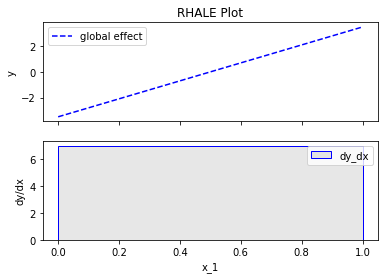

In [27]:
fig, ax1, ax2 = effector.RHALE(data=X, model=predict, model_jac=predict_grad).plot(feature=0, centering=True, show_avg_output=False)

### Heterogeneity or Uncertainty

As before, the heterogeneity is given by the the standard deviation of the instance-level effects as $\pm$ interval around the ALE plot.
It is important to notice, that automatic bin-splitting provides a better estimation of the heterogeneity, compared to the equisized binning method used by ALE. (check tutorial [ALE](./ale.ipynb) for more details). 
The plot below correctly informs shows that the heterogeneity is zero.

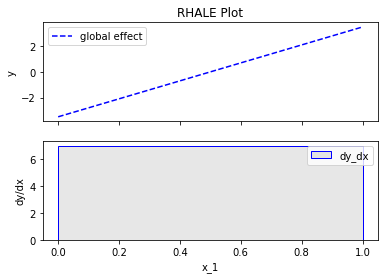

In [29]:
fig, ax1, ax2 = effector.RHALE(data=X, model=predict, model_jac=predict_grad).plot(feature=0, centering=True, confidence_interval="std", show_avg_output=False)

### Bin-Splitting

So how the automatic bin-splitting works? 

$$\text{ALE}(x_s) = \int_{z=0}^{x_s} \mathbb{E}_{x_c|x_s=z}\left [ \frac{\partial f}{\partial x_s} (z, x_c) \right ] \partial z$$

and is approximated by:

$$\hat{\text{RHALE}}(x_s) = \sum_{k=1}^{k_{x_s}} \frac{1}{ \left | \mathcal{S}_k \right |} \sum_{i: x^{(i)} \in \mathcal{S}_k} \frac{\partial f}{\partial x_s} (x_s^{(i)}, x_c^{(i)})$$


The above approximation uses a Riemannian sum to approximate the integral. The axis of the $s$-th feature is split in $K$ bins (intervals) of equal size. In each bin, the average effect of the feature of interest is estimated using the instances that fall in the bin. The average effect in each bin is called bin-effect. 

But what we saw above is different. In the figure above, only one bin has been created and covers the whole area between $x=0$ and $x=1$. 
This is because the default behaviour of `Effector` is to use an automatic bin-splitting method, as it was proposed by [Gkolemis et. al](https://arxiv.org/abs/2309.11193).
For more details about that, you can check the in-depth [ALE tutorial](./ale.ipynb).

The initial ALE proposal with K equisized bins can be achieved using the following code: 

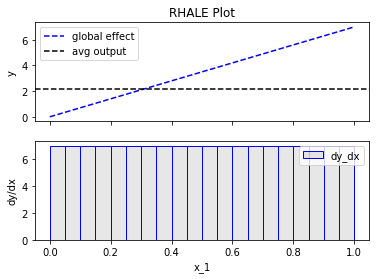

In [30]:
rhale = effector.RHALE(data=X, model=predict, model_jac=predict_grad)
binning = effector.binning_methods.Fixed(nof_bins=20, min_points_per_bin=0, cat_limit=10)
rhale.fit(features=0, binning_method=binning)
fig, ax1, ax2 = rhale.plot(feature=0)

## Conclusion

In this tutorial, we introduced the various feature effect methods of `Effector` and used them to explain a linear model. 

In summary, given a dataset `X: (N, D)` and a black-box model `model: (N, D) -> (N)`,
the feature effect plot of the $s$-th feature `feature=s` is given with the table below.
The argument `confidence_interval=True|False` indicates whether to plot the standard deviation of the instance-level effects as $\pm$ interval around the feature effect plot. Some methods also require the gradient of the model `model_jac: (N, D) -> (N, D)`.

<center>

| Method        | How to use                                                                                                                                   |
|---------------|----------------------------------------------------------------------------------------------------------------------------------------------|
| PDP           | [`effector.PDP(X, model).plot(feature, centering, confidence_interval)`]((./../../reference/#effector.pdp.PDP))                    |
| d-PDP         | [`effector.DerivativePDP(X, model, model_jac).plot(feature, centering, confidence_interval)`](./../../reference/#effector.pdp.DerivativePDP) |
| ALE           | [`effector.ALE(X, model).plot(feature, centering, confidence_interval)`](./../../reference/#effector.ale.ALE)                                |
| RHALE         | [`effector.RHALE(X, model, model_jac).plot(feature, centering, confidence_interval)`](./../../reference/#effector.ale.RHALE)                 |

</center>